<a href="https://colab.research.google.com/github/JumanaWanass/ML-Projects/blob/main/Face_Recognition_with_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition with Dimensionality Reduction and KNN

## 1. Data Preprocessing

In [ ]:
!unzip archive.zip

In [68]:
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from collections import defaultdict
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,ConfusionMatrixDisplay
import pandas as pd
import numpy as np
import seaborn as sns
import random
import cv2
import os

In [69]:
data_matrix = cp.zeros((400,10304))
label_vector = cp.zeros((400,1))

In [70]:
for i in range(1,41):
    for j in range(1,11):
        path_for_image = 's' + str(i) + "/" + str(j) + ".pgm"
        img = cp.reshape(cp.array(mpimg.imread(path_for_image)),(1,10304))
        data_matrix[(i-1)*10 + j - 1,:] = img
        label_vector[(i-1)*10 + j - 1] = i

In [71]:
# Odd rows
x_train = data_matrix[::2]
y_train = label_vector[::2]

# Even rows
x_test = data_matrix[1::2]
y_test = label_vector[1::2]

print(x_train.shape)
print(x_test.shape)

(200, 10304)
(200, 10304)


## 2. PCA

### Principal Component Analysis (PCA) Algorithm


#### 1. Standardize the Data


$ z_i = \frac{x_i - \mu_i}{\sigma_i} $

where  $\mu_i$ is the mean and $\sigma_i$ is the standard deviation of $x_i $.

### 2. Compute the Covariance Matrix


$Σ = \frac{1}{m} \sum_{i=1}^{m} (z^{(i)})^T \cdot z^{(i)} $

where $ m $ is the number of samples and $ z^{(i)} $ is the standardized feature vector of the $ i $-th sample.

### 3. Compute Eigenvectors and Eigenvalues



$Σ \cdot v = \lambda \cdot v $

where $v $ is the eigenvector and $ \lambda $ is the eigenvalue.

### 4. Sort Eigenvectors by Eigenvalues

Sort the eigenvectors in descending order based on their corresponding eigenvalues. This ensures that the principal components are ranked by the amount of variance they explain.

### 5. Select Principal Components

Choose the top $k$ eigenvectors to form the new feature space (where $ k $ is the desired number of dimensions for the reduced data).

### 6. Project Data onto the New Feature Space

Project the original data onto the selected principal components to obtain the reduced-dimensional representation of the data.

The reduced-dimensional data $ X_{\text{new}} $ is obtained by:

$ X_{\text{new}} = X \cdot W $

where $ X $ is the original standardized data and $ W $ is the matrix of selected eigenvectors.


In [72]:
Metrics = [precision_score, recall_score, f1_score]
MetricResults = defaultdict(list)
CVresults = defaultdict(list)
alpha_values = [0.8, 0.85, 0.9, 0.95]

In [73]:
def ProjectionMatrix(D):
  cov = cp.cov(D.T,bias=True)
  eigVal,eigVec = cp.linalg.eigh(cov)
  idx = eigVal.argsort()[::-1] #getting indices that would sort eigenvalues descendingly
  eigVal = eigVal[idx]
  eigVec = eigVec[:,idx]
  return eigVal,eigVec

In [74]:
def getReducedBasis(eigVal,eigVec,a):
  cumulativeSum = cp.cumsum(eigVal) #to understand the contribution of each eigenvalue to the total variability
  Eigsum = cp.sum(eigVal) #represents the total variance of data
  r = cp.argwhere((cumulativeSum/Eigsum)>=a)[0]
  return eigVec[:,:r+1]

In [75]:
def PCA(x_train, a):
  eigVal,eigVec = ProjectionMatrix(x_train)
  Ur = getReducedBasis(eigVal, eigVec, a)
  x_train_projected = cp.matmul(x_train, Ur)
  x_test_projected = cp.matmul(x_test, Ur)
  return x_train_projected, x_test_projected

In [76]:
def PCAKNN(alpha_values, x_train, y_train, x_test, y_test, CVresults, MetricResults, Metrics):
    for a in alpha_values:
        x_train_projected, x_test_projected = PCA(x_train, a)
        param = {'n_neighbors': range(1, 8, 2)}
        Knnclf = GridSearchCV(KNeighborsClassifier(), param, verbose=1)
        Knnclf.fit(cp.asnumpy(x_train_projected), cp.asnumpy(y_train.ravel()))
        y_pred = Knnclf.best_estimator_.predict(cp.asnumpy(x_test_projected))
        Knnclf.cv_results_['alpha'] = a
        CVresults['Result'].append(Knnclf.cv_results_)
        MetricResults['alpha'].append(str(a))
        MetricResults['accuracy_score'].append(accuracy_score(cp.asnumpy(y_test), y_pred))

        for metric in Metrics:
            MetricResults[metric.__name__].append(metric(cp.asnumpy(y_test), y_pred, average='macro'))

    Res = pd.DataFrame.from_records(CVresults['Result'])
    Res = Res[['alpha', 'param_n_neighbors', 'mean_test_score']].explode(['mean_test_score', 'param_n_neighbors']).reset_index(drop=True)
    Res = Res.sort_values(['mean_test_score'], ascending=False)

    return CVresults, MetricResults, Res


## 3. Data Visualization

In [77]:
CVresults, MetricResults, Res = PCAKNN(alpha_values, x_train, y_train, x_test, y_test, CVresults, MetricResults, Metrics)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


In [78]:
Res

,alpha,param_n_neighbors,mean_test_score
0,0.80,1,0.945
4,0.85,1,0.94
8,0.90,1,0.94
12,0.95,1,0.935
5,0.85,3,0.875
1,0.80,3,0.87
9,0.90,3,0.86
13,0.95,3,0.845
2,0.80,5,0.785
6,0.85,5,0.785


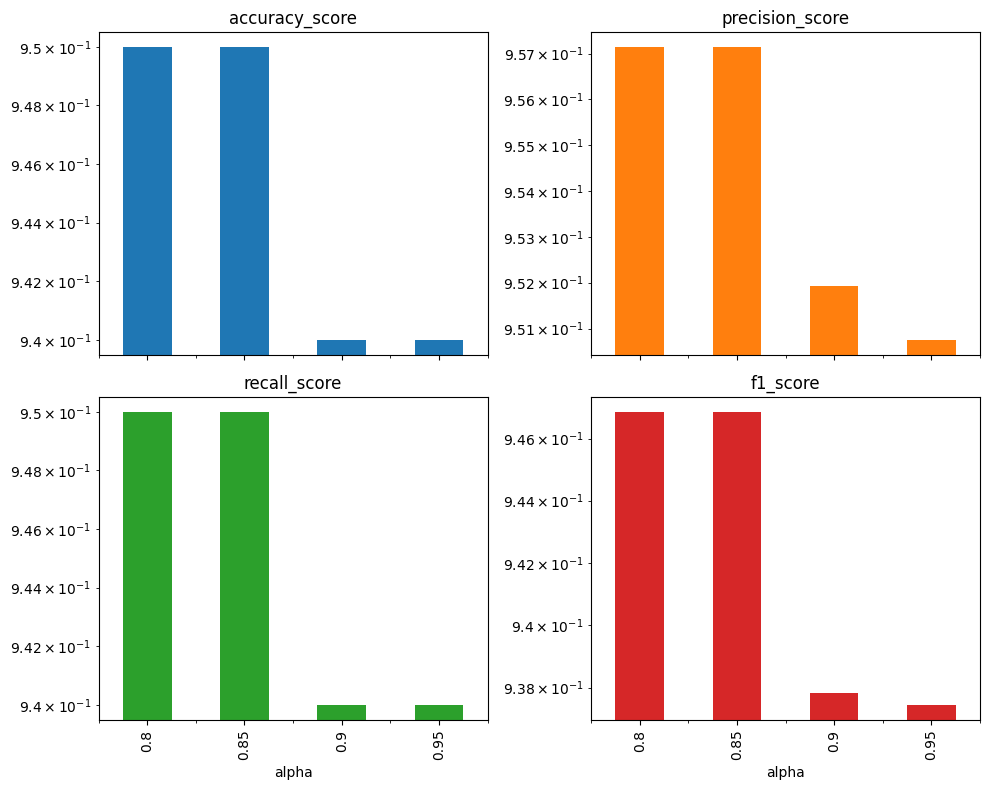

In [ ]:
ResultDF = pd.DataFrame.from_dict(MetricResults)

ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), logy=True, legend=None)
#ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), ylim=(0.5, 1),legend=None)

plt.tight_layout()
plt.show()

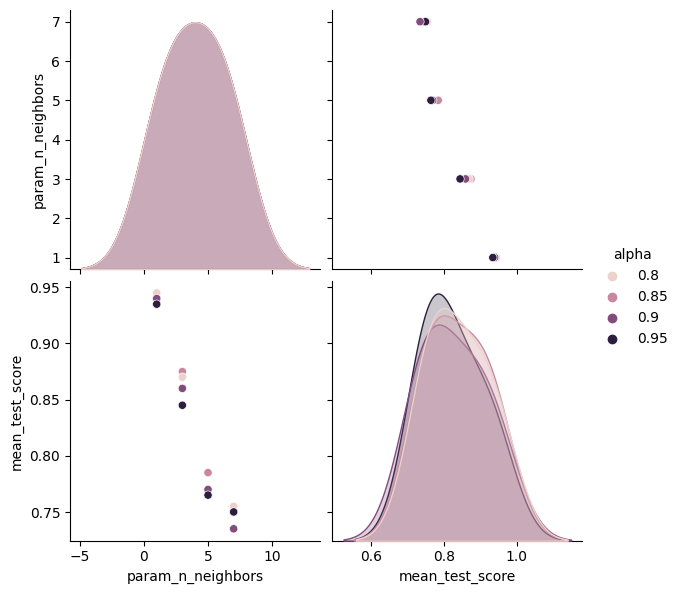

In [ ]:
visualization_data = Res[['alpha', 'param_n_neighbors', 'mean_test_score']]

sns.pairplot(visualization_data, hue='alpha', diag_kind='kde', height=3)
plt.show()


## Bonus 70 30 split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_matrix.get(), label_vector.get(), test_size=0.3, stratify=label_vector.get())
x_train = cp.asarray(x_train)
x_test = cp.asarray(x_test)
y_train = cp.asarray(y_train)

y_test = cp.asarray(y_test)

In [ ]:
eigVal,eigVec = ProjectionMatrix(x_train)

In [ ]:
Metrics = [precision_score, recall_score, f1_score]
MetricResults = defaultdict(list)
CVresults = defaultdict(list)
CVresults, MetricResults, Res = PCAKNN(alpha_values, eigVal, eigVec, x_train, y_train, x_test, y_test, CVresults, MetricResults, Metrics)
Res

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits


,alpha,param_n_neighbors,mean_test_score
4,0.85,1,0.957143
8,0.90,1,0.953571
12,0.95,1,0.95
0,0.80,1,0.939286
5,0.85,3,0.917857
1,0.80,3,0.914286
9,0.90,3,0.892857
13,0.95,3,0.885714
2,0.80,5,0.878571
6,0.85,5,0.871429


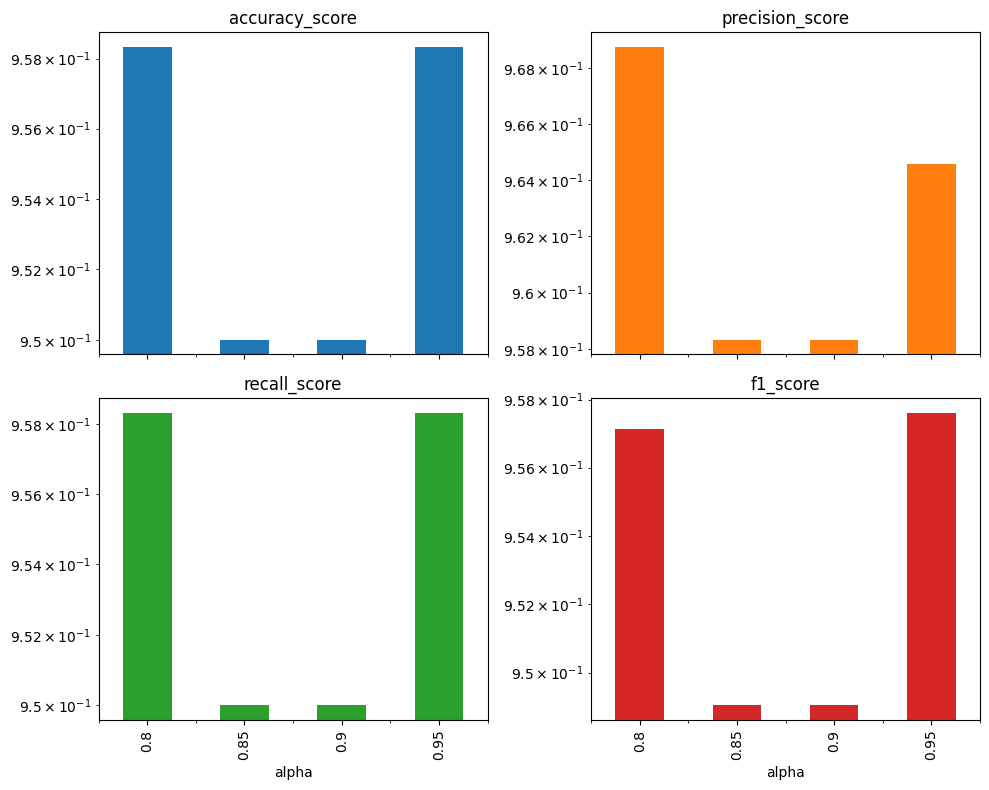

In [ ]:
ResultDF = pd.DataFrame.from_dict(MetricResults)
# Create a bar plot with separate subplots for each metric
numeric_cols = ResultDF.select_dtypes(include=[cp.number])
ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), logy=True, legend=None)
#ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), ylim=(0.5, 1),legend=None)

plt.tight_layout()
plt.show()

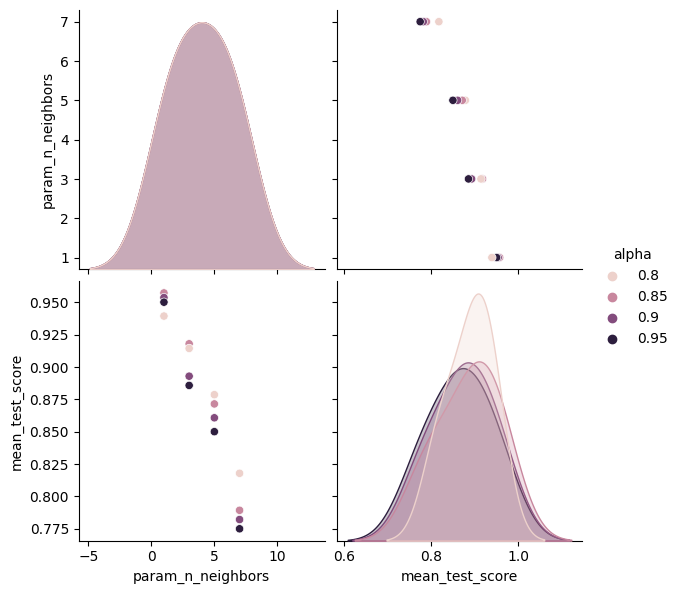

In [ ]:
visualization_data = Res[['alpha', 'param_n_neighbors', 'mean_test_score']]

# Create a pair plot to visualize relationships
sns.pairplot(visualization_data, hue='alpha', diag_kind='kde', height=3)
plt.show()


# Classifying Faces vs Non Faces

In [ ]:
!unzip pokemon.zip

In [ ]:
data_matrix_pokemon = cp.zeros((400,10304))

NameError: ignored

In [ ]:
PokemonNames = os.listdir('images/images/')
for _ in range(409):
    index = random.randint(0, len(PokemonNames) - 1)
    PokemonNames.pop(index)

In [ ]:
for i, pokemon in enumerate(PokemonNames):
    path_for_image = 'images/images/' + pokemon
    image = cv2.imread(path_for_image, cv2.IMREAD_GRAYSCALE)
    resized = cv2.resize(image, (92, 112))
    img = np.array(resized).flatten()
    cupy_image = cp.asarray(img)
    data_matrix_pokemon[i, :] = cupy_image

data_matrix = cp.zeros((400,10304))


In [ ]:
print(data_matrix_pokemon.shape)

In [ ]:
merged_data = cp.concatenate((data_matrix, data_matrix_pokemon), axis=0)

# Create labels vector
labels_data = cp.ones((data_matrix.shape[0],), dtype=cp.float32)
labels_pokemon = cp.zeros((data_matrix_pokemon.shape[0],), dtype=cp.float32)
labels = cp.concatenate((labels_data, labels_pokemon))

# Shuffle the data and labels in unison
indices = cp.arange(merged_data.shape[0])
cp.random.shuffle(indices)

shuffled_data = merged_data[indices]
shuffled_labels = labels[indices]

# Split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(shuffled_data, shuffled_labels, test_size=0.2, random_state=42)

In [ ]:
Metrics = [precision_score, recall_score, f1_score]
MetricResults = defaultdict(list)
CVresults = defaultdict(list)
alpha_values = [0.8, 0.85, 0.9, 0.95]

In [ ]:
eigVal, eigVec = ProjectionMatrix(x_train)
CVresults, MetricResults, Res = PCAKNN(alpha_values, eigVal, eigVec, x_train, y_train, x_test, y_test)

In [ ]:
CVresults, MetricResults, Res = PCAKNN(alpha_values, eigVal, eigVec, x_train, CVresults, MetricResults)

In [ ]:
ResultDF = pd.DataFrame.from_dict(MetricResults)

ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), logy=True, legend=None)
#ax = ResultDF.plot.bar(x='alpha', subplots=True, layout=(2, 2), figsize=(10, 8), ylim=(0.5, 1),legend=None)

plt.tight_layout()
plt.show()